<a href="https://colab.research.google.com/github/talesoverfables/Q-NodE/blob/main/Phase-3/Sim_v3_backend.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [69]:
!pip install qutip

# QKD Backend Simulation - Representing Room 2

In [71]:
def text_to_binary(text):
    binary_text = ''.join(format(ord(char), '08b') for char in text)
    return binary_text


In [72]:
def bb84_encrypt(binary_text):
    alice_basis = np.random.randint(2, size=len(binary_text))
    alice_state = np.array([int(bit) for bit in binary_text])
    alice_qubits = []
    for i in range(len(binary_text)):
        if alice_basis[i] == 0:
            if alice_state[i] == 0:
                alice_qubits.append(basis(2, 0))
            else:
                alice_qubits.append(basis(2, 1))
        else:
            if alice_state[i] == 0:
                alice_qubits.append(sigmax() * basis(2, 0))
            else:
                alice_qubits.append(sigmax() * basis(2, 1))
    return alice_qubits, alice_basis

In [73]:
def bb84_decrypt(alice_qubits, alice_basis, bob_basis):
    bob_qubits = [Qobj(qubit.full()) for qubit in alice_qubits]
    for i in range(len(bob_qubits)):
        if bob_basis[i] == 1:
            bob_qubits[i] = sigmax() * bob_qubits[i]
    bob_measurements = [np.random.choice([0, 1], p=[np.abs(q.full()[0, 0])**2, np.abs(q.full()[1, 0])**2]) for q in bob_qubits]
    return bob_measurements

In [74]:
def generate_secret_key(alice_basis, bob_basis, alice_qubits):
    alice_key = []
    bob_key = []
    for i in range(len(alice_basis)):
        if alice_basis[i] == bob_basis[i]:
            alice_key.append(np.random.choice([0, 1], p=[np.abs(alice_qubits[i].full()[0, 0])**2, np.abs(alice_qubits[i].full()[1, 0])**2]))
            bob_key.append(np.random.choice([0, 1], p=[np.abs(alice_qubits[i].full()[0, 0])**2, np.abs(alice_qubits[i].full()[1, 0])**2]))
    return alice_key, bob_key

In [75]:
def encrypt_message(binary_text, secret_key):
    encrypted_text = ''
    for i in range(len(binary_text)):
        encrypted_text += str(int(binary_text[i]) ^ secret_key[i % len(secret_key)])
    return encrypted_text


In [76]:
def decrypt_message(encrypted_text, secret_key):
    decrypted_text = ''
    for i in range(len(encrypted_text)):
        decrypted_text += str(int(encrypted_text[i]) ^ secret_key[i % len(secret_key)])
    return decrypted_text

In [77]:
def main():
    text = input("Enter the text to be sent: ")
    binary_text = text_to_binary(text)
    alice_qubits, alice_basis = bb84_encrypt(binary_text)
    bob_basis = np.random.randint(2, size=len(binary_text))
    bob_measurements = bb84_decrypt(alice_qubits, alice_basis, bob_basis)
    alice_key, bob_key = generate_secret_key(alice_basis, bob_basis, alice_qubits)
    encrypted_text = encrypt_message(binary_text, alice_key)
    decrypted_text = decrypt_message(encrypted_text, bob_key)
    print("Decrypted text:", ''.join([chr(int(decrypted_text[i*8:i*8+8], 2)) for i in range(len(decrypted_text)//8)]))

In [78]:

if __name__ == "__main__":
    main()

Enter the text to be sent: hello
Decrypted text: hello


# Plotting the error rate


In [81]:
def bb84_encrypt(binary_text):
    alice_basis = np.random.randint(2, size=len(binary_text))
    alice_state = np.array([int(bit) for bit in binary_text])
    alice_qubits = []
    for i in range(len(binary_text)):
        if alice_basis[i] == 0:
            if alice_state[i] == 0:
                alice_qubits.append(Qobj(basis(2, 0)))
            else:
                alice_qubits.append(Qobj(basis(2, 1)))
        else:
            if alice_state[i] == 0:
                alice_qubits.append(Qobj(sigmax() * basis(2, 0)))
            else:
                alice_qubits.append(Qobj(sigmax() * basis(2, 1)))
    return alice_qubits, alice_basis

In [82]:
def bb84_decrypt(alice_qubits, bob_basis):
    bob_qubits = []
    for i in range(len(alice_qubits)):
        if bob_basis[i] == 0:
            bob_qubits.append(alice_qubits[i])
        else:
            bob_qubits.append(sigmax() * alice_qubits[i])
    return bob_qubits

In [83]:

def measure_qubits(qubits):
    measured_qubits = []
    for qubit in qubits:
        if qubit.full()[0, 0] == 1:
            measured_qubits.append(0)
        else:
            measured_qubits.append(1)
    return measured_qubits

In [84]:
def calculate_error_rate(alice_key, bob_key):
    error_count = 0
    for i in range(len(alice_key)):
        if alice_key[i] != bob_key[i]:
            error_count += 1
    return error_count / len(alice_key)

In [85]:
def generate_secret_key(alice_basis, bob_basis, alice_qubits):
    bob_qubits = bb84_decrypt(alice_qubits, bob_basis)
    alice_key = measure_qubits(alice_qubits)
    bob_key = measure_qubits(bob_qubits)
    return alice_key, bob_key

In [86]:
def generate_graph():
    error_rates = []
    num_iterations = 1000
    num_qubits_list = [10, 50, 100, 200, 500, 1000]
    for num_qubits in num_qubits_list:
        total_error_rate = 0
        for _ in range(num_iterations):
            binary_text = np.random.randint(2, size=num_qubits)
            alice_qubits, alice_basis = bb84_encrypt(binary_text)
            bob_basis = np.random.randint(2, size=num_qubits)
            alice_key, bob_key = generate_secret_key(alice_basis, bob_basis, alice_qubits)
            total_error_rate += calculate_error_rate(alice_key, bob_key)
        error_rates.append(total_error_rate / num_iterations)
    plt.plot(num_qubits_list, error_rates)
    plt.xlabel('Number of Qubits')
    plt.ylabel('Error Rate')
    plt.title('Error Rate vs Number of Qubits')
    plt.show()

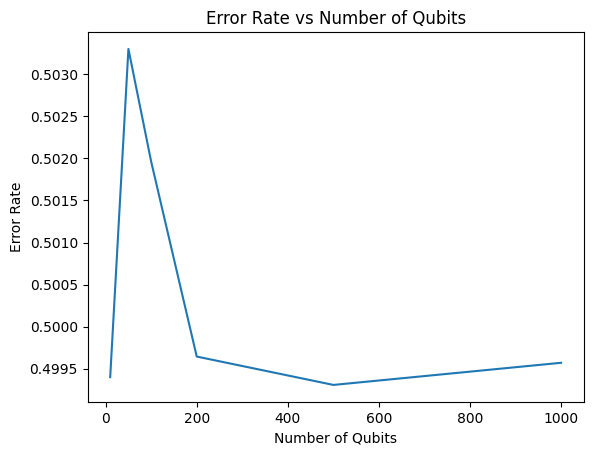

In [90]:
def main():
    generate_graph()
if __name__ == "__main__":
  main()